In [10]:
import numpy as np 
import matplotlib.pyplot as plt 
import torch 
import torch.nn as nn 
import torch.optim as optim 
import torch.nn.functional as F 
from sklearn.datasets import load_iris 
from sklearn.preprocessing import StandardScaler

In [11]:
iris = load_iris()

X, y = iris.data, iris.target 
print(f'Training data shape : {X.shape}')
print(f'Validation data shape : {y.shape}')

X_scaled = StandardScaler().fit_transform(X)

X_tensor = torch.tensor(X_scaled, dtype = torch.float32)

Training data shape : (150, 4)
Validation data shape : (150,)


In [22]:
print(X_scaled[:5])

[[-0.90068117  1.01900435 -1.34022653 -1.3154443 ]
 [-1.14301691 -0.13197948 -1.34022653 -1.3154443 ]
 [-1.38535265  0.32841405 -1.39706395 -1.3154443 ]
 [-1.50652052  0.09821729 -1.2833891  -1.3154443 ]
 [-1.02184904  1.24920112 -1.34022653 -1.3154443 ]]


In [12]:
class VAE(nn.Module):
    def __init__(self, input_dim = 4, hidden_dim = 3, latent_dim = 2):
        super(VAE, self).__init__()
        # Encoder -> Mean, Std layers
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim), 
            nn.ReLU()
        )
        self.fc_mean = nn.Linear(hidden_dim, latent_dim)
        self.fc_var = nn.Linear(hidden_dim, latent_dim) 
        # Mean, Std layers -> Decoder 
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim), 
            nn.ReLU(), 
            nn.Linear(hidden_dim, input_dim)   
        )
    
    def reparameterization(self, mean, log_var):
        # z = mean + (std)(epsilon)
        std = torch.exp(log_var*0.5)                 #std =  e ^ ((-sigma*sigma) / 2)
        epsilon = torch.randn_like(std)
        return (mean + (std)*(epsilon))

    def forward(self, x):
        # Encode
        h = self.encoder(x)
        mean, log_var = self.fc_mean(h), self.fc_var(h)
        # Reparameterize 
        z = self.reparameterization(mean, log_var)
        # Decode 
        x_recon = self.decoder(z)
        return x_recon, mean, log_var
        

In [13]:
def loss_function(x_recon, x, mean, log_var):
    # Recon loss (MSE) + KL-Divergence 
    recon_loss = F.mse_loss(x, x_recon, reduction = 'sum')
    kl_divergence = -0.5 * torch.sum(1 + log_var - (mean**2) - log_var.exp()) 
    return (recon_loss + kl_divergence)

In [14]:
model = VAE()
optimizer = optim.Adam(
    model.parameters(), 
    lr = 2e-3
)

Epoch 100, Loss: 323.3370
Epoch 200, Loss: 312.0690
Epoch 300, Loss: 325.2347
Epoch 400, Loss: 331.1526
Epoch 500, Loss: 328.3521
Epoch 600, Loss: 322.7210
Epoch 700, Loss: 330.1049
Epoch 800, Loss: 319.4413
Epoch 900, Loss: 311.8736
Epoch 1000, Loss: 325.0883


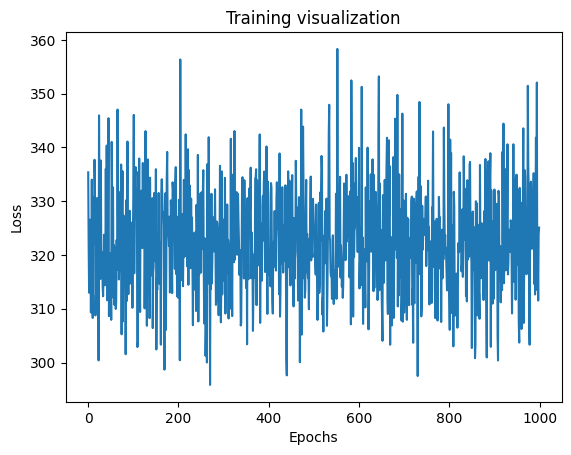

In [19]:
loss_history = []
for epoch in range(1000):
    # forward pass
    x_recon, mean, log_var = model(X_tensor)
    # loss calculation 
    loss = loss_function(x_recon, X_tensor, mean, log_var)
    # backpropagation 
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    loss_history.append(loss.detach().cpu().item())
    if (epoch+1) % 100 == 0:
        print(f'Epoch {epoch+1}, Loss: {loss.item():.4f}')

plt.plot(loss_history)
plt.title('Training visualization')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()
    

### Generate samples from latent space

In [20]:
with torch.no_grad():
    x_recon, mean, log_var = model(X_tensor)
    z = model.reparameterization(mean, log_var)
    
    random_sample_z = torch.randn(5, 2)         # random sample in latent space
    new_samples = model.decoder(random_sample_z).numpy()
    print("Generated samples (scaled):\n", new_samples)

Generated samples (scaled):
 [[-0.6409646  -0.43901896 -0.42079592 -0.45126545]
 [ 0.9979847  -0.1684928   0.97935367  0.9633882 ]
 [-0.7472157  -0.20424128 -0.6130086  -0.62834   ]
 [-0.9772629   0.27632356 -1.0164149  -0.99950016]
 [-0.7830073   2.813362   -1.8911904  -1.738983  ]]


In [28]:
with torch.no_grad():
    reconstructed = model(X_tensor)[0].numpy()
    print('Scaled original v/s reconstructed samples : \n')
    print('Original : ',X_scaled[0])
    print('Reconstructed : ',reconstructed[0])

Scaled original v/s reconstructed samples : 

Original :  [-0.90068117  1.01900435 -1.34022653 -1.3154443 ]
Reconstructed :  [-0.9010202  1.2434835 -1.3475511 -1.2788112]
